In [23]:
import pandas as pd
import numpy as np
import scanpy as sc

In [24]:
adata1=sc.read_10x_mtx("/home/gangx/data/CQX/240612/align/STARsolo.G.output/Gene/filtered",var_names="gene_ids")
adata2=sc.read_10x_mtx("/home/gangx/data/CQX/240612/align/STARsolo.I.output/Gene/filtered",var_names="gene_ids")

In [25]:
adata=adata1.concatenate(adata2,batch_categories=["Anti-G3BP1","IgG"])

/home/tmp/ipykernel_122738/453670873.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata=adata1.concatenate(adata2,batch_categories=["Anti-G3BP1","IgG"])


In [26]:
mito_genes = adata.var['gene_symbols'].str.startswith('MT-')

In [27]:
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [28]:
ribo_genes = adata.var['gene_symbols'].str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

106


In [29]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_guc=pd.read_csv("/home/gangx/data/CQX/240612/align/STARsolo.G.output/Gene/UMIperCellSorted.txt",header=None)
df_guc.reset_index(inplace=True)
df_guc['group']='Background'
df_guc.loc[df_guc['index']<7450,'group']='Cells'

In [ ]:
df_iuc=pd.read_csv("/home/gangx/data/CQX/240612/align/STARsolo.I.output/Gene/UMIperCellSorted.txt",header=None)
df_iuc.reset_index(inplace=True)
df_iuc['group']='Background'
df_iuc.loc[df_iuc['index']<6220,'group']='Cells'

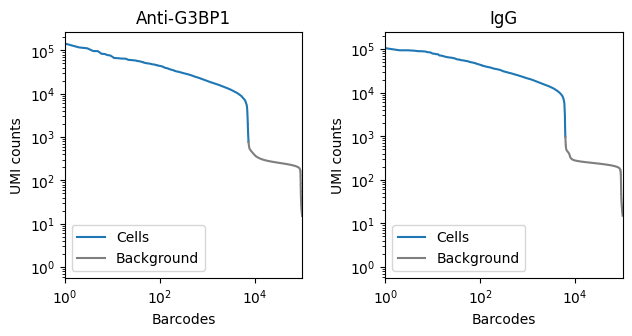

In [ ]:
plt.rcParams['figure.figsize'] = (7.2, 3.2)
fig = plt.figure()
fig.tight_layout()
ax=fig.add_subplot(1,2,1)
sns.lineplot(data=df_guc,x='index',y=0,ax=ax,hue="group",palette=["tab:blue","tab:grey"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,100000)
ax.set_xlabel("Barcodes")
ax.set_ylabel("UMI counts")
ax.set_title("Anti-G3BP1")
ax.legend(ncol=1)
ax=fig.add_subplot(1,2,2)
sns.lineplot(data=df_iuc,x='index',y=0,ax=ax,hue="group",palette=["tab:blue","tab:grey"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,100000)
ax.set_xlabel("Barcodes")
ax.set_ylabel("UMI counts")
ax.set_title("IgG")
ax.legend(ncol=1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35)

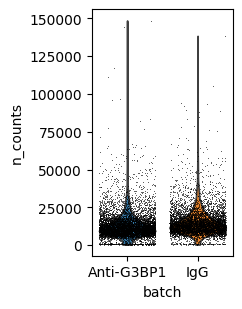

In [ ]:
plt.rcParams['figure.figsize'] = (4, 3.2)
fig = plt.figure()
fig.tight_layout()
ax=fig.add_subplot(121)
sc.pl.violin(adata, ['n_counts'],size=0.5,
             jitter=0.4, groupby = 'batch',ax=ax)
ax=fig.add_subplot(122)
sc.pl.violin(adata, [ 'n_counts'],
             jitter=0.4, groupby = 'batch',ax=ax)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35)

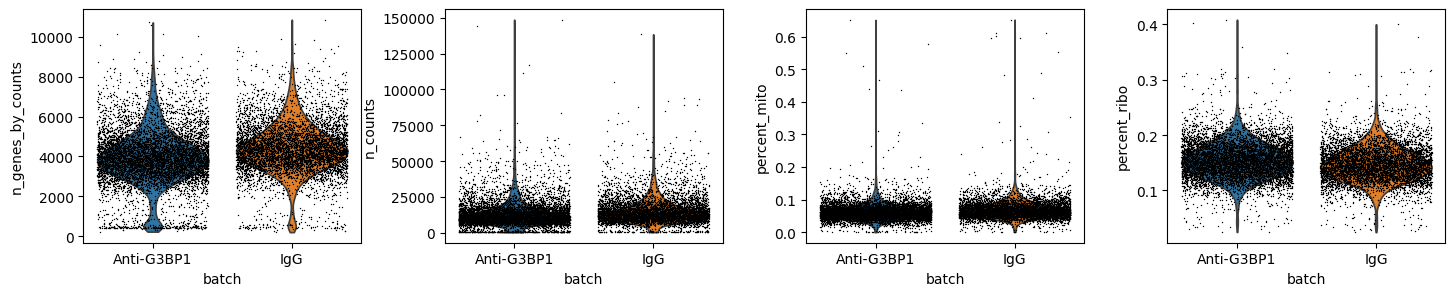

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'batch')

In [ ]:
adata.obs['total_counts'].min()

500.0

In [30]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

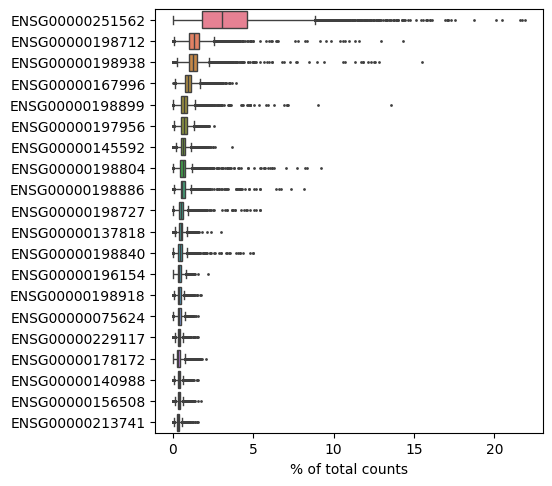

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [109]:
adata.obs[(adata.obs['total_counts']>=10000)&(adata.obs['percent_ribo']>0.05)&(adata.obs['percent_ribo']<0.3)&(adata.obs['percent_mito']<0.2)&(adata.obs['n_genes']>2000)&(adata.obs['n_genes_by_counts']>4000)]['batch'].value_counts()

batch
IgG           3945
Anti-G3BP1    3400
Name: count, dtype: int64

In [31]:
adata=adata[(adata.obs['total_counts']>=10000)&(adata.obs['percent_ribo']>0.05)&(adata.obs['percent_ribo']<0.3)&(adata.obs['percent_mito']<0.2)&(adata.obs['n_genes']>2000)&(adata.obs['n_genes_by_counts']>4000)]

In [132]:
adata.X=adata.X.toarray()

In [32]:
adata.write_h5ad("10xMapit_rawcounts.h5ad")

/home/gangx/apps/miniconda3/envs/Mapit-seq/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/gangx/apps/miniconda3/envs/Mapit-seq/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [128]:
adata.var=adata.var.reset_index().set_index("gene_symbols")

In [43]:
adata.raw=adata

In [37]:
adata.obs['barcode']=pd.Series(adata.obs.index).apply(lambda x:x.split("-")[0]).tolist()

In [45]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [46]:
sc.pp.log1p(adata)

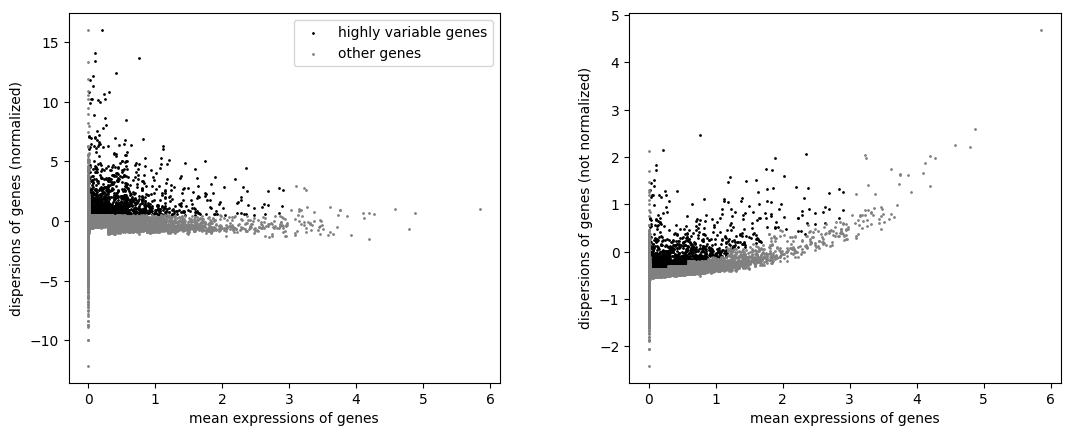

In [47]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [48]:
sc.pp.scale(adata)

In [ ]:
adata_hv = adata[:, adata.var['highly_variable']]

In [40]:
def geteditevent(path):
    df_edit=pd.read_csv(path+"/edit_gene.tsv",sep="\t")
    df_cov=pd.read_csv(path+"/genecov.txt",sep="\t",header=None)
    return pd.DataFrame(index=[path[-18:]],data={"EDIT":[df_edit["EDIT"].sum()],"BASECOV":[df_cov[1].sum()]})

In [35]:
import subprocess
import multiprocessing
from tqdm import tqdm

In [38]:
adata.obs['path']="/home/gangx/data/CQX/240612/splitbam/"+adata.obs['batch'].astype(str).replace({"Anti-G3BP1":"G","IgG":"I"})+"/"+adata.obs['barcode'].astype(str)

In [41]:
with multiprocessing.Pool(20) as pool:
    r = list(tqdm(pool.imap(geteditevent, adata.obs['path'].tolist()), total=len(adata.obs['path'].tolist())))

100%|██████████| 7345/7345 [00:19<00:00, 380.20it/s]


In [42]:
df_ee=pd.concat(r)

In [43]:
df_ee.reset_index(inplace=True)

In [44]:
df_ee['EDITDEN']=df_ee['EDIT']/df_ee['BASECOV']*1e6

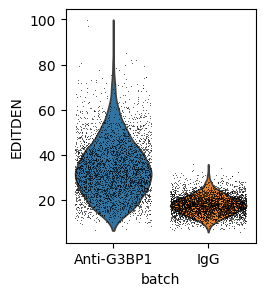

In [45]:
adata.obs['EDITDEN']=df_ee['EDITDEN'].tolist()
sc.pl.violin(adata, ['EDITDEN'],size=0.5,
             jitter=0.4, groupby = 'batch')

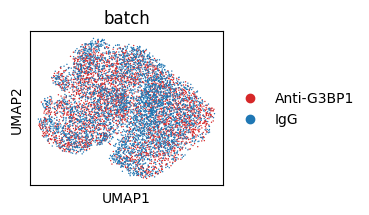

In [ ]:
plt.rcParams['figure.figsize'] = (2.5, 2)
fig = plt.figure()
fig.tight_layout()
ax=fig.add_subplot(111)
sc.pl.umap(adata,color='batch',ax=ax,size=4,palette=["tab:red","tab:blue"])


In [50]:
def mergeEdit(path):
    df_scedit=pd.read_csv(path+"/edit_gene.tsv",sep="\t")
    df_scedit['GENEID']=df_scedit['geneid'].apply(lambda x:x.split(".")[0])
    df_scedit.rename(columns={'EDIT%':path[-18:]},inplace=True)
    return df_scedit.set_index("GENEID")[[path[-18:]]]

In [47]:
import subprocess
import multiprocessing
from tqdm import tqdm
import os

In [51]:
with multiprocessing.Pool(40) as pool:
    r = list(tqdm(pool.imap(mergeEdit, sorted(tbamlist)), total=len(tbamlist)))

100%|██████████| 7345/7345 [00:02<00:00, 2688.28it/s]


In [52]:
df_scedit=pd.concat(r,axis=1,join="outer").fillna(0)

In [ ]:
df_scedit_t=df_scedit.T.apply(np.log1p)

In [ ]:
df_scedit_t.insert(0,'batch',adata.obs['batch'].tolist())
df_scedit_t.insert(0,'phase',adata.obs['phase'].tolist())

In [53]:
df_scedit=pd.merge(pd.DataFrame(index=adata.var.index),df_scedit,left_index=True,right_index=True)

In [82]:
from scipy import sparse

In [83]:
adata_edit=sc.AnnData(sparse.csc_matrix(df_scedit.T),obs=pd.DataFrame(index=df_scedit.columns),var=pd.DataFrame(index=df_scedit.index))

In [85]:
adata_edit.obs.index=(pd.Series(adata_edit.obs.index).apply(lambda x:x.split("/")[1])+pd.Series(adata_edit.obs.index).apply(lambda x:x.split("/")[0]).replace({"G":"-Anti-G3BP1","I":"-IgG"})).tolist()

In [86]:
adata_edit.obs['batch']=adata.obs['batch']
adata_edit.obs['editingdensity']=adata.obs['EDITDEN']

In [87]:
adata_edit.var=pd.merge(adata_edit.var,adata.var[["gene_symbols"]],left_index=True,right_index=True,how="left")

In [ ]:
df_scedit.columns.tolist()==adata.obs['path'].apply(lambda x:x[-18:]).tolist()

True

In [ ]:
adata_edit.obs['batch']=adata.obs['batch'].tolist()
adata_edit.obs['phase']=adata.obs['phase'].tolist()
adata_edit.obs['leiden']=adata.obs['leiden'].tolist()

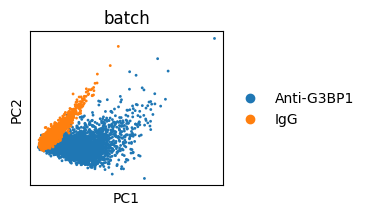

In [ ]:
sc.tl.pca(adata_edit)
sc.pl.pca_scatter(adata_edit, color='batch')

In [ ]:
sc.pp.neighbors(adata_edit, n_neighbors=80, n_pcs=40)
sc.tl.umap(adata_edit,min_dist=0.8)

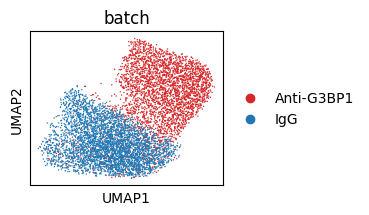

In [ ]:
plt.rcParams['figure.figsize'] = (2.5, 2)
fig = plt.figure()
fig.tight_layout()
ax=fig.add_subplot(111)
sc.pl.umap(adata_edit,color='batch',ax=ax,size=4,palette=["tab:red","tab:blue"])

In [ ]:
adata_edit.write_h5ad("./10xMapit_edit.h5ad")